In [47]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import networkx as nx

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torchview import draw_graph
from torchviz import make_dot

In [64]:
from torch.utils.tensorboard import SummaryWriter

# Set up TensorBoard logging directory
writer = SummaryWriter('runs/GCN_experiment_1')

# 1a. Load Data

In [70]:
os.listdir('data/web-of-life_2024-04-29_062424/M_PA_004.csv')

['M_PA_004.csv',
 'references.csv',
 'M_PA_005.csv',
 'M_PA_002.csv',
 'M_PA_003.csv',
 'M_PA_001.csv',
 'README']

In [16]:
ifp = 'data/web-of-life_2024-04-28_035253'
fps = [fp for fp in os.listdir('data/web-of-life_2024-04-28_035253') if fp[:2] == 'FW']
fps

['FW_014_02.csv',
 'FW_014_01.csv',
 'FW_016_01.csv',
 'FW_010.csv',
 'FW_004.csv',
 'FW_005.csv',
 'FW_012_01.csv',
 'FW_007.csv',
 'FW_006.csv',
 'FW_012_02.csv',
 'FW_002.csv',
 'FW_003.csv',
 'FW_001.csv',
 'FW_015_01.csv',
 'FW_015_03.csv',
 'FW_015_02.csv',
 'FW_009.csv',
 'FW_013_02.csv',
 'FW_013_03.csv',
 'FW_013_01.csv',
 'FW_013_04.csv',
 'FW_013_05.csv']

In [72]:
apfp = 'data/web-of-life_2024-04-29_062424/M_PA_004.csv'
df = pd.read_csv(apfp)
df = df.drop(df.columns[0], axis=1)
df = df.drop(df.columns[0], axis=1)
df.head()

,Adenia heterophylla,Aleurites rockinghamensis,Archontophoenix alexandrae,Archontophoenix alexandrae.1,Ardisia pachyrrhachis,Cardwellia sublimis,Castanospermum australe,Clerodendrum tracyanum,Crotalaria sp1 M_PA_004,Cryptocarya hypospodia,...,Stephania japonica,Syzygium cormiflorum,Syzygium erythrocalyx,Syzygium gustavioides,Syzygium sayeri,Toona ciliata,Trichosanthes pentaphylla,Unidentified sp1 M_PA_004,Urena lobata,Wrightia laevis subsp. millgar
0,4,1,1,3,18,4,4,5,1,1,...,1,1,14,1,1,1,2,1,1,2
1,1,0,0,0,1,1,2,0,0,0,...,0,0,8,1,1,0,0,0,0,0
2,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
A = df.values
N = A.shape[0]
D = 100
X = np.random.random(size=(N, D))
y = np.array(df.columns)

In [74]:
A = torch.from_numpy(A).type(torch.FloatTensor)
X = torch.from_numpy(X).type(torch.FloatTensor)

edge_index = A.nonzero().t()
node_features = X
data = Data(x=node_features, edge_index=edge_index, y=y)

In [ ]:
def to_graph_object(fp, dim=100):
    

# 1b. Visualize Data

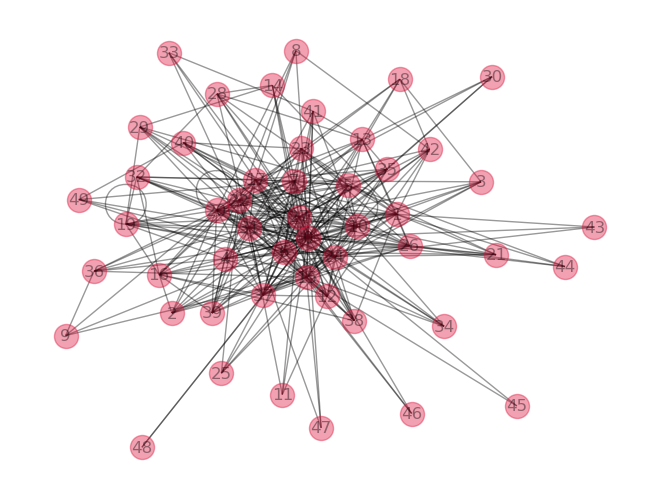

In [77]:
G = to_networkx(data, to_undirected=True)
nx.draw(G, with_labels=True, node_color='crimson', alpha=0.4)
plt.show()

# 2. Construct Model

In [41]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(D, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        return x

model = GCN(hidden_channels=16)

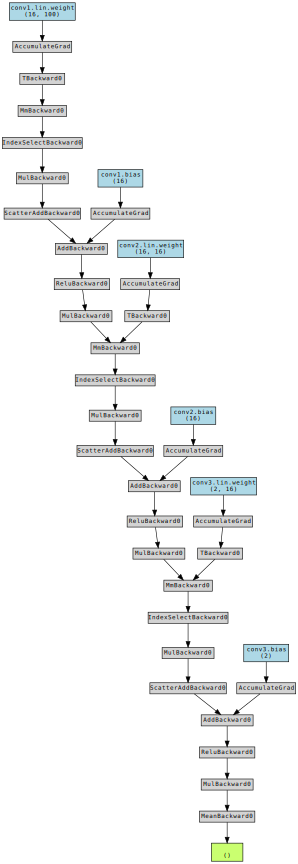

In [45]:
y = model(data.x, data.edge_index)
make_dot(y.mean(), params=dict(model.named_parameters()))

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
inputs = (data.x.to(device), data.edge_index.to(device))
model = model.to(device)

# Pass a batch of data to log the model graph
writer.add_graph(model, inputs)

In [67]:
writer.close()

In [68]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# 3. Visualize Model

In [ ]:
model = MLP()
batch_size = 2
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size, 128), device='meta')
model_graph.visual_graph